In [1]:
import warnings
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
warnings.filterwarnings('ignore')

## Load data

In [2]:
NUM_CLASSES = 4
CLASSES_TO_KEEP = [0, 1, 2, 3]

In [3]:
data = pd.read_csv('california.csv')
data.target = np.floor(data.target * NUM_CLASSES/5).astype('uint8')
data = data[data.target.apply(lambda x: x in CLASSES_TO_KEEP)]
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,3
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,2
2,2.0804,42.0,4.294118,1.117647,1206.0,2.026891,37.84,-122.26,1
3,2.1250,50.0,4.242424,1.071970,697.0,2.640152,37.85,-122.26,1
4,1.9911,50.0,5.343675,1.085919,990.0,2.362768,37.84,-122.26,1


## Stratify

In [4]:
train, test = train_test_split(data, stratify=data.target, random_state=42)
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

## Normalize

In [5]:
mu = train.loc[:,:'Longitude'].mean()
sigma = train.loc[:,:'Longitude'].std()

train.loc[:,:'Longitude'] = (train.loc[:,:'Longitude'] - mu) / sigma
test.loc[:,:'Longitude'] = (test.loc[:,:'Longitude'] - mu)/sigma

## Verify stratification and priors

In [6]:
priors = pd.DataFrame({
    'train': train.target.value_counts() / len(train),
    'test' : test.target.value_counts() / len(test)
})
priors

,train,test
1,0.483303,0.483437
0,0.278195,0.278209
2,0.188972,0.188923
3,0.049530,0.049431


## Class conditionals

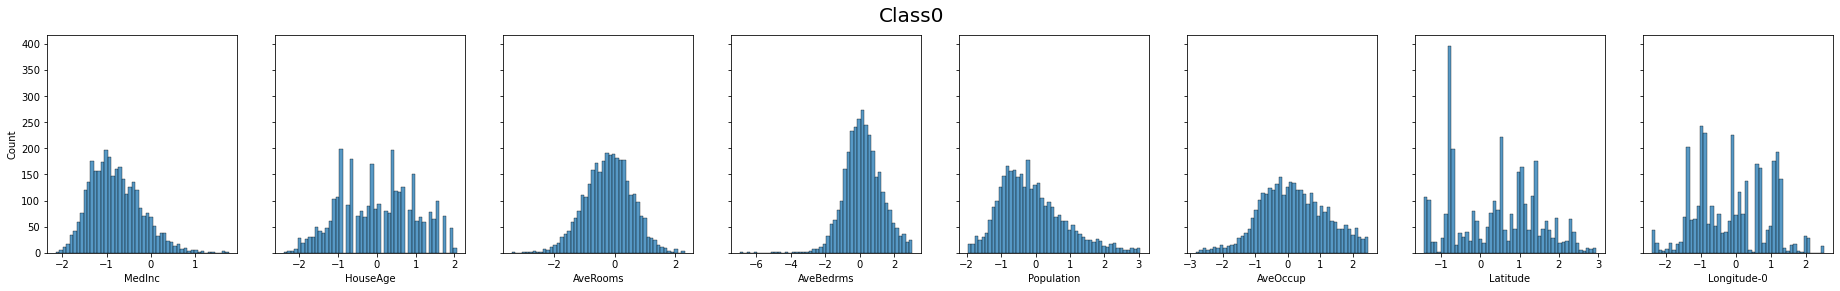

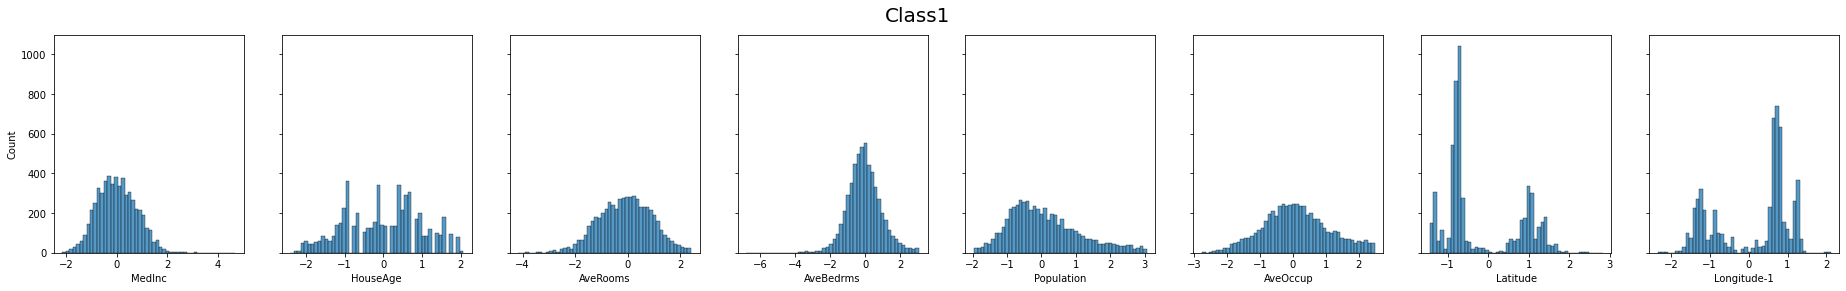

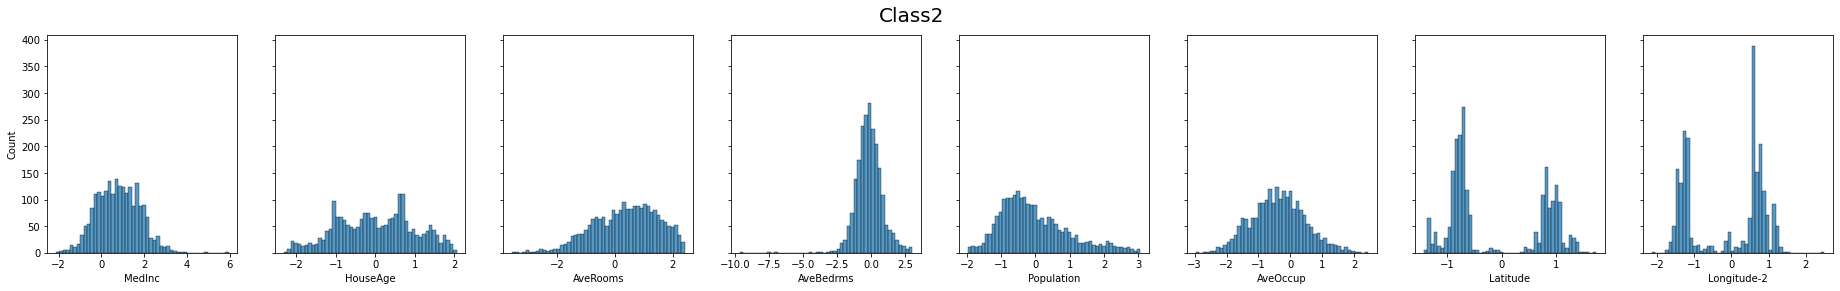

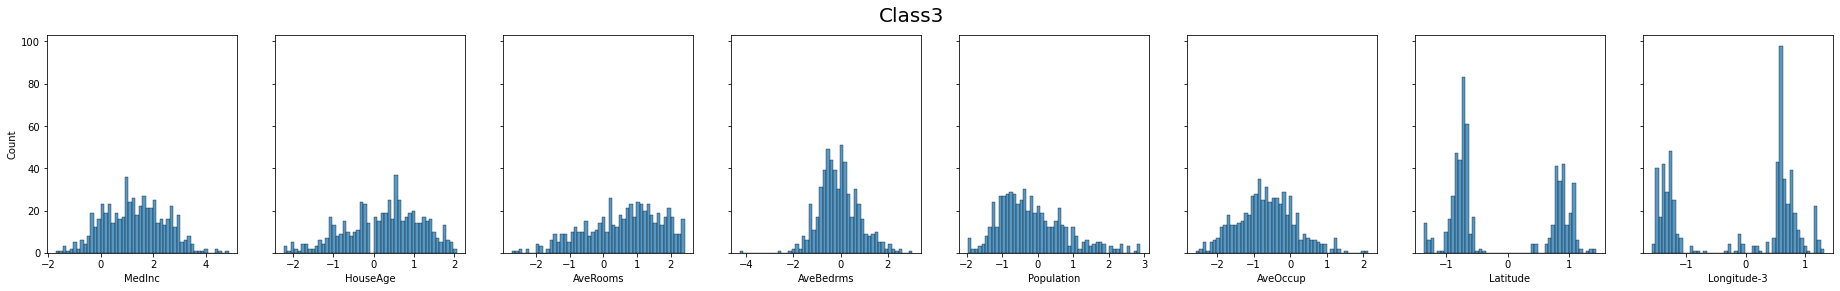

In [14]:
for c in np.unique(train.target):
    fig, axs = plt.subplots(1, 8, figsize=(32, 4), sharey=True)
    fig.suptitle(f'Class{c}', fontsize=20)
    for i, col in enumerate(train):
        if col == 'target':
            continue
        sns.histplot(train[col][train.target == c], bins=50, ax=axs[i])
        plt.xlabel(f"{col}-{c}")   
    plt.show()


## Baseline using Gaussian Naive Bayes library

In [8]:
model = GaussianNB().fit(train.loc[:,:'Longitude'], train.target)
preds = model.predict(train.loc[:,:'Longitude'])
print("Train Accuracy: ", (train.target == preds).mean())

preds = model.predict(test.loc[:,:'Longitude'])
print("Test Accuracy: ", (test.target == preds).mean())

Train Accuracy:  0.6206747778065407
Test Accuracy:  0.6130952380952381


## Purely Gaussian Model

Train accuracy:  0.7023039088791095
Test accuracy:  0.7005693581780539


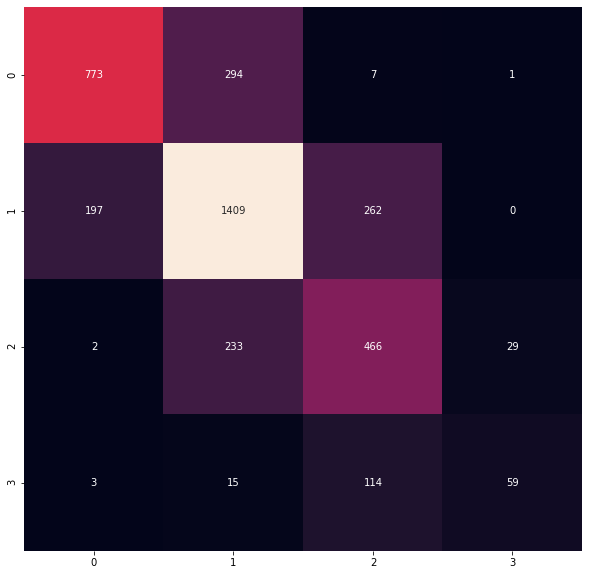

In [9]:
class ClassConditionalGaussianModel:
    def __init__(self, prior, mean, covInv, covDet):
        self.prior = prior
        self.mean = mean
        self.covInv = covInv
        self.denominator = np.sqrt(covDet)
        
    def posteriorProbScaled(self, x):
        z = x - self.mean
        numerator = self.prior * np.exp(-0.5 * np.diagonal(z @ self.covInv @ z.T) )
        return numerator/self.denominator

def predict(models, x):
    if type(x) != np.ndarray:
        x = np.array(x)
    return np.array([model.posteriorProbScaled(x) for model in models]).T.argmax(axis=1)

def getModels(train, classes=CLASSES_TO_KEEP):
    X = np.array(train.loc[:,:'Longitude'])
    y = np.array(train.target)
    
    idx = [y==i for i in classes] # X[idx[0]] gives all examples with target class 0
    priors = [j.mean() for j in idx] # priors is fraction of times each class appears in the dataset
    
    means = [ X[j].mean(axis=0) for j in idx ] #classwise means
    
    covs = [ np.cov(X[j], rowvar=False) for j in idx ]
    covInvs = [ np.linalg.inv(c) for c in covs ]
    covDets = [ np.linalg.det(c) for c in covs ]
    
    return [        
        ClassConditionalGaussianModel(priors[i], means[i], covInvs[i], covDets[i])
        for i in classes
    ]

models = getModels(train)

preds = predict(models, train.loc[:,:'Longitude'])
print("Train accuracy: ", (train.target == preds).mean())

preds = predict(models, test.loc[:,:'Longitude'])
print("Test accuracy: ", (test.target == preds).mean())

cm = confusion_matrix(test.target, preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False);

In [10]:
for idx, model in enumerate(models):
    print(f"Class={idx}")
    print(model.mean*sigma + mu)
    print()

Class=0
MedInc           2.504669
HouseAge        27.900744
AveRooms         4.933895
AveBedrms        1.060380
Population    1223.525744
AveOccup         2.964980
Latitude        36.490009
Longitude     -119.761849
dtype: float64

Class=1
MedInc           3.696961
HouseAge        27.555972
AveRooms         5.058622
AveBedrms        1.043416
Population    1349.341725
AveOccup         2.917437
Latitude        35.252585
Longitude     -119.330689
dtype: float64

Class=2
MedInc           4.843889
HouseAge        28.195890
AveRooms         5.538185
AveBedrms        1.037055
Population    1267.654338
AveOccup         2.632513
Latitude        35.381589
Longitude     -119.786110
dtype: float64

Class=3
MedInc           5.598729
HouseAge        30.804878
AveRooms         5.758608
AveBedrms        1.041611
Population    1187.033101
AveOccup         2.466298
Latitude        35.344460
Longitude     -119.817125
dtype: float64



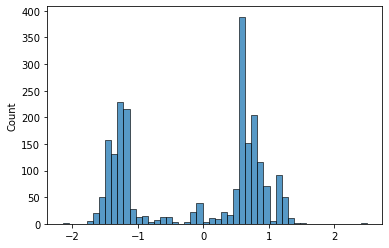

In [32]:
X = np.array(train['Longitude'][train.target == 2])
sns.histplot(X, bins=50);

In [186]:
class GaussianMixtureModel:
    def __init__(self, nclus=2):
        self.mu = np.array([-1, 1]).reshape((1,-1))
        self.sigma = np.ones((1, nclus))
        self.lbd  = np.ones((1, nclus)) / nclus
        self.nclus = nclus
    
    def normalPDF(self, X): # x is vector, m and s are numbers
        z = (X - self.mu) / self.sigma
        dn = self.sigma * (2 * np.pi)**.5
        return np.exp(-0.5 * z**2) / dn
    
    def getGamma(self, X, normalize=True):
        N = self.normalPDF(X)
        G = self.lbd * N
        if normalize:
            G /= G.sum(axis=1, keepdims=True)
        return G
    
    def predictProba(self, X):
        X = X.reshape((-1, 1)) # data is a col, params are rows
        G = self.lbd * self.normalPDF(X)
        return G.sum(axis=1)
    
    def fit(self, X, n_rounds=10):
        X = X.reshape((-1, 1)) # data is a col, params are rows
        m, n = X.shape[0], self.nclus
        
        for _ in range(n_rounds):
            # E_step gamma_ij is [m, n]
            gamma = self.getGamma(X)
            
            # M_step assigning new values
            sumGammaI = gamma.sum(axis=0, keepdims=True) # [1, n] 
            xmu = (X-self.mu) # m, n -> m,
            self.sigma = (gamma * (X - self.mu)**2).sum(axis=0, keepdims=True) / sumGammaI # sum([m, n] * [m, n], 0) =  [1, n]
            self.sigma = self.sigma ** .5
            self.mu = (X.T @ gamma) / sumGammaI   # [1, m] @ [m, n] -> [1, n]
            self.lbd = sumGammaI / m
        return self
    
    def plot(self, X, ax):
        ax.hist(X, bins=20, density=True)
        dummyX = np.linspace(X.min(), X.max(), num=100).reshape((-1, 1))

        y = self.predictProba(dummyX)
        ax.plot(dummyX, y)

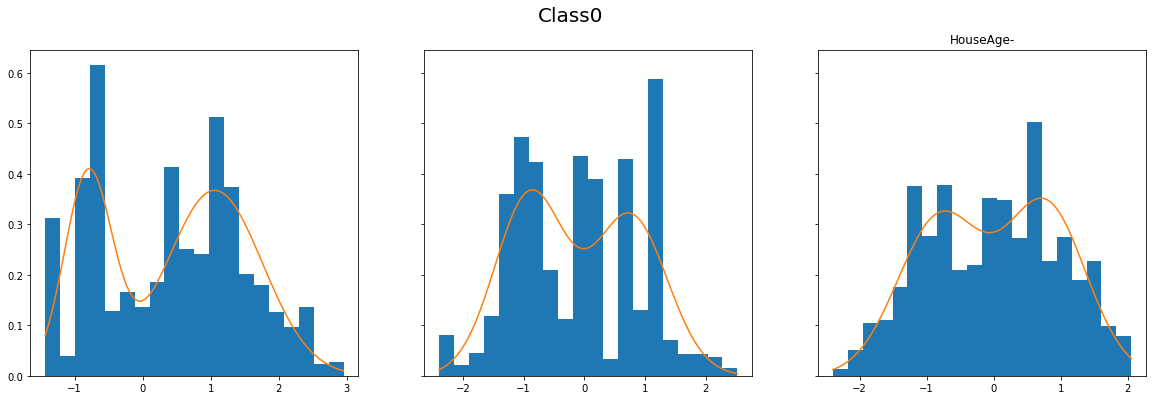

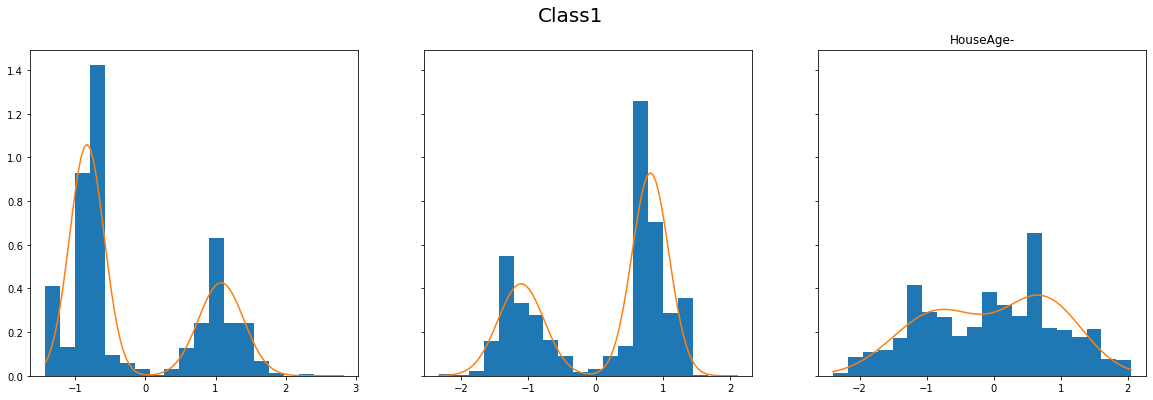

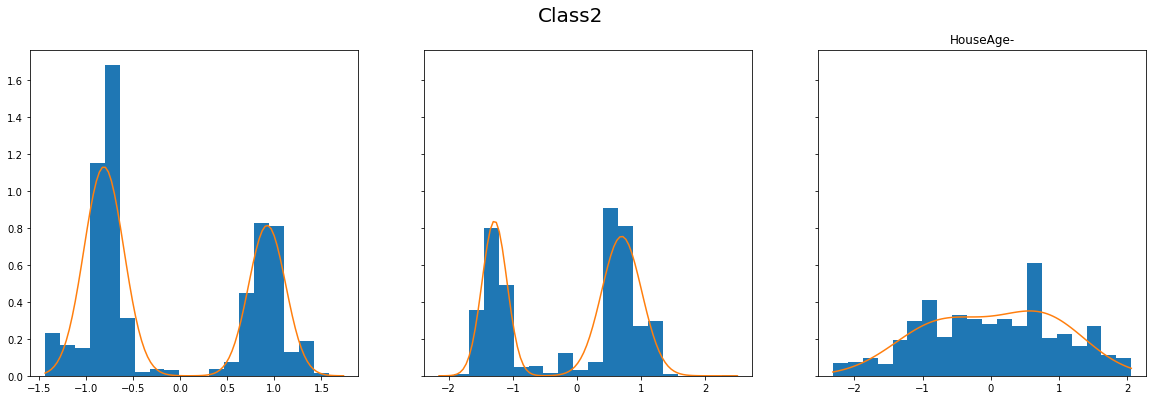

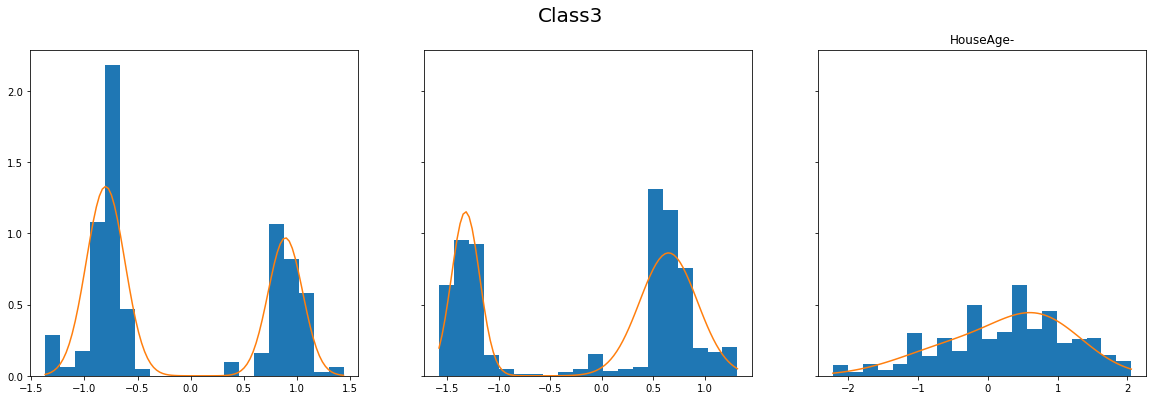

In [205]:
for c in np.unique(train.target):
    fig, axs = plt.subplots(1, 3, figsize=(20, 6), sharey=True)
    fig.suptitle(f'Class{c}', fontsize=20)
    for i, col in enumerate("Latitude Longitude HouseAge".split()):
        X = np.array(train[col][train.target == c])
        model = GaussianMixtureModel().fit(X, 10)
        model.plot(X, axs[i])
        plt.title(f'{col}-')

## GMM for latitude, longitude and Gaussian for remaining

Train accuracy:  0.6595047027353524
Test accuracy:  0.662008281573499


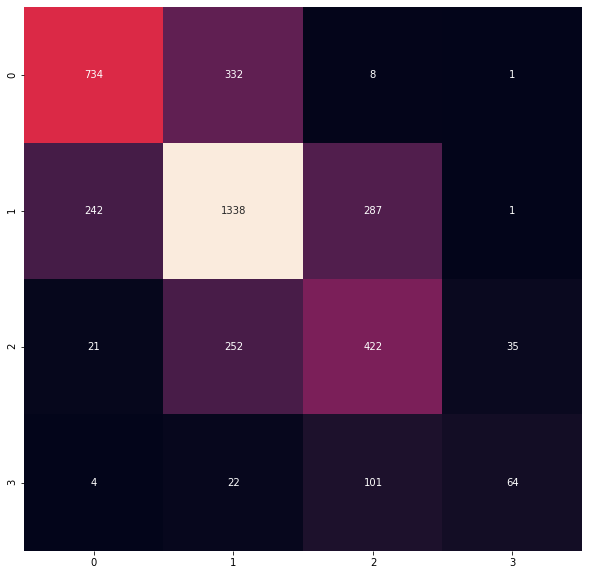

In [210]:
GaussianPart = ['MedInc', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'HouseAge']
GmmPart = ['Latitude', 'Longitude']

class ClassConditionalSpecialModel:
    def __init__(self, prior, mean, covInv, covDet, gmModels):
        self.prior = prior
        self.mean = mean
        self.covInv = covInv
        self.denominator = np.sqrt(covDet)
        self.gmModels = gmModels
        
    def posteriorProbScaled(self, x):
        z = np.array(x[GaussianPart] - self.mean)
        numerator = np.exp(-0.5 * np.diagonal(z @ self.covInv @ z.T) )
        gauss = numerator/self.denominator
        gmmProb = 1
        for gmCol, gmModel in zip(GmmPart, self.gmModels):
            gmmProb *= gmModel.predictProba(np.array(x[gmCol]))
        return self.prior * gauss * gmmProb

def predict(models, x):
    return np.array([model.posteriorProbScaled(x) for model in models]).T.argmax(axis=1)

def getModels(train, classes=CLASSES_TO_KEEP):
    # similar to fit function
    X = np.array(train[GaussianPart])
    y = np.array(train.target)
    
    idx = [y==i for i in classes] # X[idx[0]] gives all examples with target class 0
    priors = [j.mean() for j in idx] # priors is fraction of times each class appears in the dataset
    
    means = [ X[j].mean(axis=0) for j in idx ] #classwise means
    
    covs = [ np.cov(X[j], rowvar=False) for j in idx ]
    covInvs = [ np.linalg.inv(c) for c in covs ]
    covDets = [ np.linalg.det(c) for c in covs ]
    
    gmModels = [
        # each class has one model for lat and one for long
        [ GaussianMixtureModel().fit( np.array(train[col][j]) ) for col in GmmPart ]
        for j in idx
    ]
    return [        
        ClassConditionalSpecialModel(priors[i], means[i], covInvs[i], covDets[i], gmModels[i])
        for i in range(len(classes))
    ]

models = getModels(train)

preds = predict(models, train.loc[:,:'Longitude'])
print("Train accuracy: ", (train.target == preds).mean())

preds = predict(models, test.loc[:,:'Longitude'])
print("Test accuracy: ", (test.target == preds).mean())

cm = confusion_matrix(test.target, preds)
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='.0f', cbar=False);